# Recovery of gold from ore

The company develops solutions for the efficient operation of industrial enterprises. It is necessary to prepare a prototype of a machine learning model that will predict the recovery rate of gold from gold-bearing ore. We use data with extraction and purification parameters. The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

Tasks:

1. Prepare the data;
2. Conduct a exploratory data analysis;
3. Build and train a model.

To solve the problem, we will introduce a new quality metric — sMAPE (Symmetrical Mean Absolute Percentage Error)

$$sMAPE = \frac{1}{N}\sum_{i=1}^{N} \frac{|y_i - \bar{y_i}|}{|y_i + \bar{y_i}| / 2}$$

\\(y_i\\)-the value of the target attribute for the object with the ordinal number i in the sample on which the quality is measured.  
\\(\bar{y_i}\\)-the prediction value for an object with the ordinal number i, for example, in a test sample.  
\\(N\\)-the number of objects in the sample.

## Loading libraris and data

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

plt.style.use('dark_background')
RANDOM_STATE = 42

In [3]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

## Data preparation

Let's check the correctness of the calculation of rougher.output.recovery

In [4]:
check_recovery = (df_train['rougher.output.concentrate_au'] * (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au'])\
/ (df_train['rougher.input.feed_au'] * (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au'])))\
* 100

In [5]:
mean_absolute_error(df_train['rougher.output.recovery'], check_recovery)

9.73512347450521e-15

MAE tends to zero, we can conclude that **recovery** is calculated correctly. Let's check the features that aren't available in the test sample.

In [6]:
set(df_train.columns)-set(df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In the test sample, output data is not available at different stages, which is logical, because we need to predict the characteristics before starting production so that it is not unprofitable.

### Checking duplicates

In [7]:
df_train.duplicated().sum(), df_test.duplicated().sum(), df_full.duplicated().sum()

(0, 0, 0)

### Checking missing values

In [8]:
df_train.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [9]:
df_test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [10]:
df_full.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

We found a lot of omissions in various signs, but since the neighboring parameters are often similar in time, we will fill in the omissions with the method *ffil*.

In [11]:
df_train = df_train.ffill()
df_test = df_test.ffill()

In [12]:
df_train.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [13]:
df_test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5290 non-null   float64
 2   primary_cleaner.input.depressant            5290 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14149 non-null  float64
 2   final.output.concentrate_pb                         14149 non-null  float64
 3   final.output.concentrate_sol                        14149 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14149 non-null  float64
 8   final.output.tail_sol                               14149 non-null  float64


In [16]:
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5290.000000,5290.000000,5290.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.842478,8.684695,7.266339,1.383430,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.023252,3.073753,0.610219,0.643548,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489556,6.890000,0.907390,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052131,7.250000,1.197586,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.028043,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


## Data analysis

### Distribution of metal concentration at different stages

Let's build a graph and check the concentration of different metals at different stages of purification.

In [17]:
x = ['rougher.input', 'rougher.ouput', 'primary_cleaner','final']
y_au = [df_train['rougher.input.feed_au'].median(),
    df_train['rougher.output.concentrate_au'].median(),
    df_train['primary_cleaner.output.concentrate_au'].median(),
    df_train['final.output.concentrate_au'].median()]

In [18]:
y_ag = [df_train['rougher.input.feed_ag'].median(),
    df_train['rougher.output.concentrate_ag'].median(),
    df_train['primary_cleaner.output.concentrate_ag'].median(),
    df_train['final.output.concentrate_ag'].median()]

In [19]:
y_pb = [df_train['rougher.input.feed_pb'].median(),
    df_train['rougher.output.concentrate_pb'].median(),
    df_train['primary_cleaner.output.concentrate_pb'].median(),
    df_train['final.output.concentrate_pb'].median()]

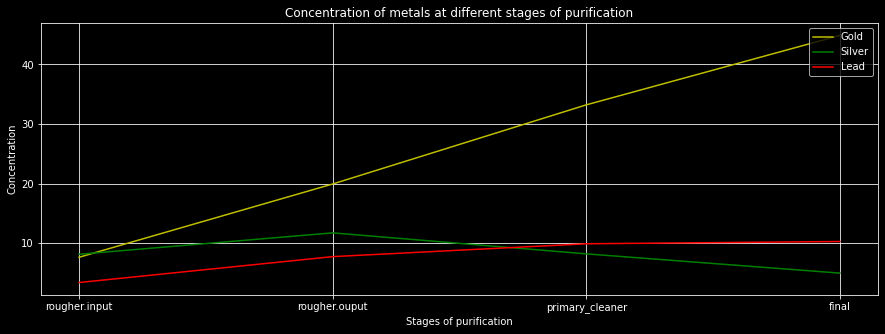

In [20]:
fig = plt.figure(figsize=(15,5))
plt.plot(x, y_au, label='Gold', c='y')
plt.plot(x, y_ag, label='Silver', c='g')
plt.plot(x, y_pb, label='Lead', c='r')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Stages of purification')
plt.ylabel('Concentration')
plt.title('Concentration of metals at different stages of purification');

The concentration of gold is constantly increasing at different stages of purification, which cannot be said about other metals. Lead practically changes slightly, and silver begins to fall by the end of cleaning.

### Comparison of the distribution of raw material granules in a training and test sample.

In [21]:
train = df_train['rougher.input.feed_size']

In [22]:
test = df_test['rougher.input.feed_size']

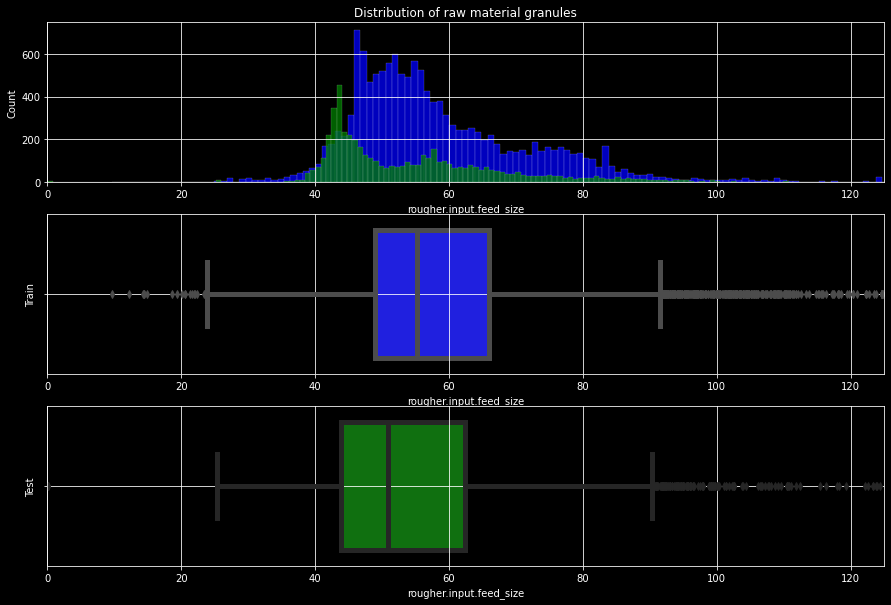

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,10))

sns.histplot(data=df_train, x="rougher.input.feed_size", color ='blue', label='train', bins=500, ax=ax1)
sns.histplot(data=df_test, x="rougher.input.feed_size", color='green', label='test', bins=500, ax=ax1)
sns.boxplot(data=train, x=train, ax=ax2, color ='blue', linewidth=5)
sns.boxplot(data=test, x=test, ax=ax3, color ='green', linewidth=5)
ax1.set_xlim(0, 125)
ax2.set_xlim(0, 125)
ax3.set_xlim(0, 125)
ax1.grid()
ax2.grid()
ax3.grid()
ax3.set_ylabel('Test')
ax2.set_ylabel('Train')
ax1.set_title('Distribution of raw material granules');

The distribution of raw material granules in the training and test samples does not differ much from each other. Let's check the total concentration of all substances at different stages.

### Investigation of the total concentration of all substances at different stages: in raw materials, in rough and final concentrates.

In [24]:
rougher_input = df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_ag']\
    + df_train['rougher.output.concentrate_pb']
rougher_output = df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_pb']\
         + df_train['rougher.output.concentrate_au']
final_output = df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_pb']\
         + df_train['final.output.concentrate_au']

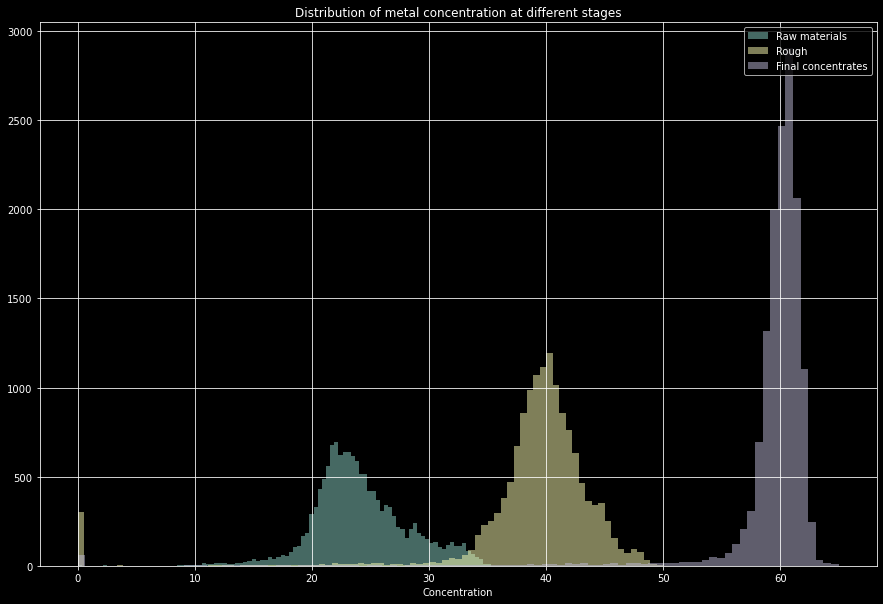

In [25]:
fig = plt.figure(figsize=(15,10))
plt.hist(rougher_input, bins = 100, alpha=0.5, label='Raw materials')
plt.hist(rougher_output, bins = 100, alpha=0.5, label='Rough')
plt.hist(final_output, bins = 100, alpha=0.5, label='Final concentrates')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Concentration')
plt.title('Distribution of metal concentration at different stages');

There are anomalies in the data when the concentration of metals is zero at the stage of roughing and final concentrates.

In [26]:
df_train.loc[(rougher_output == 0) | (final_output == 0), ['rougher.input.feed_au', 'rougher.input.feed_ag',
                                                        'rougher.input.feed_pb', 'rougher.output.concentrate_ag',
                                                        'rougher.output.concentrate_pb', 'rougher.output.concentrate_au',
                                                        'final.output.concentrate_ag', 'final.output.concentrate_pb',
                                                        'final.output.concentrate_au']]

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_au
45,7.114065,7.521974,2.811569,0.0,0.0,0.0,4.566664,10.406178,46.614456
46,7.651522,7.313187,2.973841,0.0,0.0,0.0,4.577832,10.691605,46.250638
47,5.587750,7.934791,1.763437,0.0,0.0,0.0,4.591462,10.628846,46.663335
48,4.752992,7.756881,1.025762,0.0,0.0,0.0,5.296830,10.597469,44.015642
49,5.122801,5.393466,1.824835,0.0,0.0,0.0,8.162896,8.877528,40.715973
...,...,...,...,...,...,...,...,...,...
10330,7.951063,8.576019,2.607144,0.0,0.0,0.0,4.909904,9.941006,47.660737
10331,8.715784,8.640039,2.905023,0.0,0.0,0.0,4.797572,9.889303,47.801056
10332,9.026122,8.769059,3.020251,0.0,0.0,0.0,4.329492,9.413122,49.412576
10333,8.752430,8.705607,2.881386,0.0,0.0,0.0,4.317169,9.642271,48.839994


Let's get rid of the anomalies.

In [27]:
df_train = df_train[(rougher_output != 0) & (final_output != 0)]

In [28]:
df_train.shape

(13795, 87)

In [29]:
rougher_input = df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_ag']\
    + df_train['rougher.output.concentrate_pb']
rougher_output = df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_pb']\
         + df_train['rougher.output.concentrate_au']
final_output = df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_pb']\
         + df_train['final.output.concentrate_au']

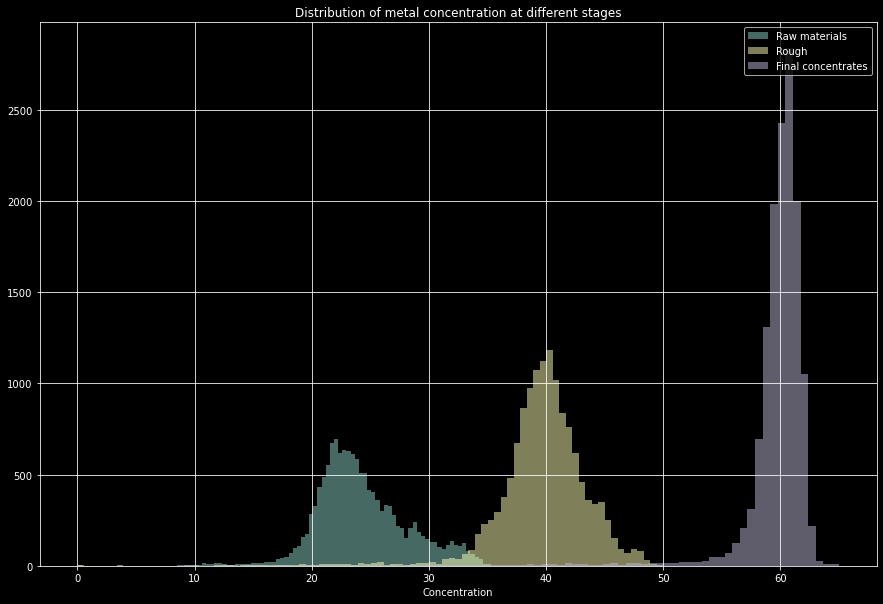

In [30]:
fig = plt.figure(figsize=(15,10))
plt.hist(rougher_input, bins = 100, alpha=0.5, label='Raw materials')
plt.hist(rougher_output, bins = 100, alpha=0.5, label='Rough')
plt.hist(final_output, bins = 100, alpha=0.5, label='Final concentrates')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Concentration')
plt.title('Distribution of metal concentration at different stages');

We got rid of the anomalies, we move on to building a model.

## Building and training models

### The function for calculating the final sMAPE

In [31]:
def smape(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred)) / 2

    return np.mean(error / scale) * 100

In [32]:
def final_smape(smape_rougher, smape_final):
    return 0.25 * (smape_rougher * -1).mean() + 0.75 *(smape_final * -1).mean()

### Creating train and test samples

In [33]:
X_test = df_test.drop('date', axis=1)
X_train = df_train[df_test.drop('date', axis=1).columns]

y_train_final = df_train['final.output.recovery']
y_train_rougher = df_train['rougher.output.recovery']

In [34]:
X_train.shape, X_test.shape, y_train_final.shape, y_train_rougher.shape

((13795, 52), (5290, 52), (13795,), (13795,))

In [35]:
len(df_test) / len(df_full)

0.2721333401923967

Test sample size equal 27% of full sample size, so we need to use 4 folds in GridSearchCV

In [36]:
# creating scorer
scorer = make_scorer(smape, greater_is_better = False)

### Ridge

In [37]:
X_train_rd = X_train.copy()
y_train_final_rd = y_train_final.copy()
y_train_rougher_rd = y_train_rougher.copy()

In [38]:
pipeline_rd = Pipeline([('std', StandardScaler()),
                       ('rd', Ridge(random_state=RANDOM_STATE))])

params_rd = {'rd__alpha': range(10, 21),
            'rd__max_iter': range(100, 500, 100)}
grid_rd = GridSearchCV(pipeline_rd, params_rd, scoring=scorer, cv=4, n_jobs=-1)

grid_rd.fit(X_train_rd, y_train_rougher_rd)
param_rougher_rd = grid_rd.best_params_
model_rougher_rd = grid_rd.best_estimator_
smape_rougher_rd = grid_rd.best_score_

grid_rd.fit(X_train_rd, y_train_final_rd)
param_final_rd = grid_rd.best_params_
model_final_rd = grid_rd.best_estimator_
smape_final_rd = grid_rd.best_score_

In [39]:
smape_rd = final_smape(smape_rougher_rd, smape_final_rd)

In [40]:
smape_rd, param_rougher_rd, param_final_rd

(10.09611784442441,
 {'rd__alpha': 20, 'rd__max_iter': 100},
 {'rd__alpha': 20, 'rd__max_iter': 100})

### RandomForestRegressor

In [41]:
X_train_rf = X_train.copy()
y_train_final_rf = y_train_final.copy()
y_train_rougher_rf = y_train_rougher.copy()

In [42]:
pipeline_rf = Pipeline([('std', StandardScaler()),
                       ('rf', RandomForestRegressor(random_state=RANDOM_STATE))])

params_rf = {'rf__n_estimators': range(500, 1500, 100),
            'rf__max_depth': [3, 5, 7]}
grid_rf = GridSearchCV(pipeline_rf, params_rf, scoring=scorer, cv=4, n_jobs=-1)

grid_rf.fit(X_train_rf, y_train_rougher_rf)
param_rougher_rf = grid_rf.best_params_
model_rougher_rf = grid_rf.best_estimator_
smape_rougher_rf = grid_rf.best_score_

grid_rf.fit(X_train_rf, y_train_final_rf)
param_final_rf = grid_rf.best_params_
model_final_rf = grid_rf.best_estimator_
smape_final_rf = grid_rf.best_score_

In [43]:
smape_rf = final_smape(smape_rougher_rf, smape_final_rf)

In [44]:
smape_rf, param_rougher_rf, param_final_rf

(9.379037332642593,
 {'rf__max_depth': 5, 'rf__n_estimators': 600},
 {'rf__max_depth': 7, 'rf__n_estimators': 800})

### CatBoostRegressor

In [45]:
X_train_ct = X_train.copy()
y_train_final_ct = y_train_final.copy()
y_train_rougher_ct = y_train_rougher.copy()

In [46]:
pipeline_ct = Pipeline([('std', StandardScaler()),
                       ('ct', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])

params_ct = {'ct__n_estimators': range(500, 1500, 100),
            'ct__max_depth': [3, 5, 7]}
grid_ct = GridSearchCV(pipeline_ct, params_ct, scoring=scorer, cv=4, n_jobs=-1)

grid_ct.fit(X_train_ct, y_train_rougher_ct)
param_rougher_ct = grid_ct.best_params_
model_rougher_ct = grid_ct.best_estimator_
smape_rougher_ct = grid_ct.best_score_

grid_ct.fit(X_train_ct, y_train_final_ct)
param_final_ct = grid_ct.best_params_
model_final_ct = grid_ct.best_estimator_
smape_final_ct = grid_ct.best_score_

In [47]:
smape_ct = final_smape(smape_rougher_ct, smape_final_ct)

In [48]:
grid_ct.best_params_

{'ct__max_depth': 7, 'ct__n_estimators': 1300}

In [49]:
smape_ct, param_rougher_ct, param_final_ct

(8.632694782121012,
 {'ct__max_depth': 7, 'ct__n_estimators': 1000},
 {'ct__max_depth': 7, 'ct__n_estimators': 1300})

### Training results

In [50]:
pd.DataFrame({'SMAPE':[smape_rd, smape_rf, smape_ct],
             'model_rougher': [param_rougher_rd, param_rougher_rf, param_rougher_ct],
             'model_final': [param_final_rd, param_final_rf, param_final_ct]},
            index=['Ridge', 'RandomForestRegressor', 'CatBoostRegressor'])

,SMAPE,model_rougher,model_final
Ridge,10.096118,"{'rd__alpha': 20, 'rd__max_iter': 100}","{'rd__alpha': 20, 'rd__max_iter': 100}"
RandomForestRegressor,9.379037,"{'rf__max_depth': 5, 'rf__n_estimators': 600}","{'rf__max_depth': 7, 'rf__n_estimators': 800}"
CatBoostRegressor,8.632695,"{'ct__max_depth': 7, 'ct__n_estimators': 1000}","{'ct__max_depth': 7, 'ct__n_estimators': 1300}"


### Checking on test sample

In [51]:
y_test_rougher = model_rougher_ct.predict(X_test)

In [52]:
y_test_final = model_final_ct.predict(X_test)

In [53]:
df_test['y_test_rougher.output.recovery'] = y_test_rougher

In [54]:
df_test['y_test_final.output.recovery'] = y_test_final

In [55]:
df_full['date'].nunique()

19439

In [56]:
len(df_full)

19439

Since all values in the date column are unique, we will combine the test sample with the predicted values with the true recovery values and calculate the final smape.

In [57]:
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date')

In [58]:
smape_rougher_test = 0.25 * smape(df_test['rougher.output.recovery'], df_test['y_test_rougher.output.recovery'])\
    + 0.75 * smape(df_test['final.output.recovery'], df_test['y_test_final.output.recovery'])

In [59]:
smape_rougher_test

9.079969251096403

We will output the first 5 samples with the best final predicted enrichment efficiency.

In [60]:
df_test.sort_values('y_test_final.output.recovery', ascending=False).head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,y_test_rougher.output.recovery,y_test_final.output.recovery,rougher.output.recovery,final.output.recovery
1098,2016-10-26 21:59:59,153.866395,5.493614,7.45,0.697818,1645.805852,-499.716325,1701.235581,-500.094936,1702.488493,...,16.969908,-500.221575,13.997210,-500.585791,24.993328,-500.741037,89.179114,76.227018,90.929819,76.181774
789,2016-10-13 22:59:59,202.750119,12.008059,8.08,0.693339,1631.873982,-499.283846,1702.704938,-499.779034,1701.483957,...,10.579428,-493.518149,8.038947,-500.373033,16.998926,-499.756835,88.642793,75.952089,89.436332,75.092431
4864,2017-12-11 21:59:59,159.218110,10.475866,8.24,0.968343,1552.647709,-499.458425,1551.056910,-500.571240,1550.273613,...,10.970499,-499.104477,7.988255,-499.516784,12.003673,-500.007881,88.714441,75.936510,91.059014,79.448818
2560,2016-12-29 12:59:59,142.762878,9.051808,8.02,1.081957,1625.406795,-500.089380,1688.626352,-499.339928,1706.042057,...,14.119404,-499.711514,11.977003,-499.511914,20.999498,-499.851805,88.946613,75.777274,85.775524,73.065769
1100,2016-10-26 23:59:59,159.471023,6.151160,7.45,0.704721,1645.007022,-499.379004,1702.105146,-500.080313,1701.860176,...,17.011571,-499.378893,13.958884,-500.507788,24.981145,-498.906192,88.601967,75.724797,90.001648,75.419914


## Conclusion
The training dataset with extraction and purification parameters was investigated. We checked the concentration of metals at each stage of purification, got rid of anomalies. The distribution of raw material granules in the training and test samples have minor discrepancies, which should not affect the quality of the model. Based on the results of training on the training dataset , the best model was determined using cross validation . We tested the model on a test dataset and compared it with the true values of rougher.output.recovery and final.output.recovery. The final sMAPE metric turned out to be 9.08%